In [1]:
import hubert_model
import librosa
import  torch
from icassp2022_vocal_transcription import transcribe
import numpy as np
from models import SynthesizerTrn
import utils
import IPython.display as ipd
import matplotlib.pyplot as plt

[ 2  4  6 10  2  4  8 10]


In [2]:
hubert = hubert_model.hubert_soft("hubert-soft-0d54a1f4.pt")

In [3]:
def get_units(in_path, hubert_soft):
    source, sr = librosa.load(in_path, 16000)
    source = torch.FloatTensor(source)
    source = source.unsqueeze(0)
    source = source.unsqueeze(0)
    with torch.inference_mode():
        units = hubert_soft.units(source)
        return units
# get_units("/Users/xingyijin/Downloads/odds(1).wav", hubert).shape


In [4]:
def resize_pitch(source, target_len):
    source = source.astype(float)
    source_len = source.shape[0]
    source[source<0.001] = np.nan
    target = np.zeros([target_len])
    for i in range(target_len):
        target[i] = source[int(source_len*i/target_len)]

    res = np.nan_to_num(target)
    ret = res[:].astype(int)
    return ret

In [5]:
soft = get_units("/Users/xingyijin/Downloads/odds(1).wav", hubert)
pitch = transcribe("/Users/xingyijin/Downloads/odds(1).wav")
pitch = resize_pitch(pitch, soft.shape[1])
pitch = torch.LongTensor(pitch).unsqueeze(0)

/var/folders/36/6m8zyz714bg9_1lb7qry0kzr0000gn/T/ipykernel_19955/1445350203.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  source, sr = librosa.load(in_path, 16000)


DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=86)
           2	LOAD_GLOBAL(arg=0, lineno=86)
           4	LOAD_FAST(arg=0, lineno=86)
           6	LOAD_FAST(arg=1, lineno=86)
           8	LOAD_FAST(arg=2, lineno=86)
          10	LOAD_FAST(arg=3, lineno=86)
          12	LOAD_FAST(arg=4, lineno=86)
          14	LOAD_FAST(arg=5, lineno=86)
          16	LOAD_FAST(arg=6, lineno=86)
          18	CALL_FUNCTION(arg=7, lineno=86)
          20	POP_TOP(arg=None, lineno=86)
          22	LOAD_CONST(arg=0, lineno=86)
          24	RETURN_VALUE(arg=None, lineno=86)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=86)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=86)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=86)
DEBUG:n

2022-10-14 16:05:55.085601: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 2s 2s/step


/Users/xingyijin/Documents/github-projects/so-vits-svc/icassp2022_vocal_transcription/src/quantization.py:26: FutureWarning: Pass y=[ 78. 319. 522. ... 100.  84.  64.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_strength = librosa.onset.onset_strength(y, sr=target_sr)


In [6]:
hps = utils.get_hparams_from_file("configs/nyarumul.json")

net = SynthesizerTrn(
    178,
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model)

In [7]:
_ = utils.load_checkpoint("/Users/xingyijin/Downloads/216_epochs.pth", net, None)

INFO:root:Loaded checkpoint '/Users/xingyijin/Downloads/216_epochs.pth' (iteration None)


In [8]:
# net.n_speakers =

In [9]:
sid = torch.LongTensor([0])
x_lengths = torch.LongTensor([soft.size(1)])
audio = net.infer(soft, x_lengths, pitch, sid, 0.3)[0][0,0].data.float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))


/var/folders/36/6m8zyz714bg9_1lb7qry0kzr0000gn/T/ipykernel_74378/3682349879.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = pitch.numpy().astype(np.float)


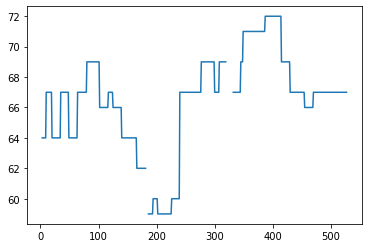

In [16]:
import matplotlib.pyplot as plt
p = pitch.numpy().astype(np.float)
p[p == 0] = np.nan
plt.plot(p[0,:])